In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import time
import sklearn.model_selection as skm

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 6.3MB/s 


In [3]:
import tensorflow_addons as tfa
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
import sys

sys.path.append("./gdrive/MyDrive/wildlife/Archeys_frogs")
from LandMarkDataGenerator import LandMarkDataGenerator
from LocalizationPointAccuracy import LocalizationPointAccuracy
from CNNBlock import CNNBlock

In [34]:
DB_FILE_PATH = r"./gdrive/MyDrive/wildlife/Archeys_frogs/image_path_anotations_db.pkl"
IMAGE_SIZE = (512, 512)
IMAGE_SIZE_WIDTH_INDEX = 0
IMAGE_SIZE_HEIGHT_INDEX = 1

In [6]:
def show_labels(
    img,
    labels,
    labels_real=None,
    radius=5,
    thickness=1,
    radius_real=10,
    color=(0, 0, 255),
    color_real=(0, 255, 0),
):
    for i in range(0, len(labels), 2):
        point = np.round([labels[i], labels[i + 1]]).astype(int)
        point = tuple(point)
        img = cv2.circle(img, point, radius, color, thickness)
        if labels_real is not None:
            point = np.round([labels_real[i], labels_real[i + 1]]).astype(int)
            point = tuple(point)
            img = cv2.circle(img, point, radius, color_real, thickness)
            img = cv2.circle(img, point, radius_real, color_real, thickness)
    cv2_imshow(img * 255)

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history, since_step=10):
    gs = gridspec.GridSpec(3, 3)
    fig = plt.figure(tight_layout=True)
    ax1 = fig.add_subplot(gs[0, :])
    # plot loss
    # plt.subplot(211)
    ax1.set_title("Loss")
    ax1.plot(history.history["loss"][since_step:], color="blue", label="train")
    ax1.plot(history.history["val_loss"][since_step:], color="orange", label="test")
    # plot accuracy
    # plt.subplot(213)
    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title("Classification Accuracy")
    ax2.plot(
        history.history["localization_point_accuracy_radius_4.2"][since_step:],
        color="blue",
        label="train",
    )
    ax2.plot(
        history.history["val_localization_point_accuracy_radius_4.2"][since_step:],
        color="orange",
        label="test",
    )

    ax2 = fig.add_subplot(gs[2, :])
    ax2.set_title("Outside Radius Distance")
    ax2.plot(
        history.history["localization_outside_radius_4.2_distance"][since_step:],
        color="blue",
        label="train",
    )
    ax2.plot(
        history.history["val_localization_outside_radius_4.2_distance"][since_step:],
        color="orange",
        label="test",
    )

    plt.show()

In [8]:
train_df = pd.read_pickle("./gdrive/MyDrive/wildlife/Archeys_frogs/train_db.pkl")
val_df = pd.read_pickle("./gdrive/MyDrive/wildlife/Archeys_frogs/val_db.pkl")
test_df = pd.read_pickle("./gdrive/MyDrive/wildlife/Archeys_frogs/test_db.pkl")

In [9]:
val_df.head()

,image_path,x_Left_eye,y_Left_eye,x_Left_front_leg,y_Left_front_leg,x_Right_eye,y_Right_eye,x_Right_front_leg,y_Right_front_leg,x_Tip_of_snout,y_Tip_of_snout,x_Vent,y_Vent,original_width_size,original_height_size
0,/content/gdrive/MyDrive/wildlife/Archeys_frogs...,1126.923096,1039.332031,1264.653076,994.205688,1067.585571,816.122070,1248.020020,763.907959,993.965820,941.991577,1594.713135,811.385010,2628,1656
1,/content/gdrive/MyDrive/wildlife/Archeys_frogs...,835.882019,1003.133301,1045.608887,1037.514771,816.972229,791.687378,1037.013550,759.025024,693.198975,912.022400,1351.603882,886.236328,1904,1840
2,/content/gdrive/MyDrive/wildlife/Archeys_frogs...,659.071533,958.224365,800.676270,904.644104,594.009827,772.607178,752.836792,707.545593,536.602478,896.989807,1095.367310,680.755615,1468,1624
3,/content/gdrive/MyDrive/wildlife/Archeys_frogs...,542.385498,919.639771,737.690491,963.251587,578.412659,720.542542,781.302246,697.788574,447.577301,794.492920,1088.480957,847.585571,1734,1599
4,/content/gdrive/MyDrive/wildlife/Archeys_frogs...,510.699005,720.994263,629.830688,785.975220,552.665833,542.296692,743.547363,573.433411,418.642670,603.216309,1002.117432,730.470642,1632,1449


In [35]:
gt = LandMarkDataGenerator(
    dataframe=train_df,
    x_col="image_path",
    y_col=train_df.columns.to_list()[1:],
    color_mode="rgb",
    target_size=IMAGE_SIZE,
    batch_size=5,
    rotate=(-90, 90),
    scale=(0.9, 1.1),
    translate_percent=(-0.1, 0.1),
    multiply=(0.9, 1.1),
    multiply_per_channel=True,
    training=True,
    resize_points=True,
    height_first=False,
)

Found 1304 validated image filenames.


In [36]:
gv = LandMarkDataGenerator(
    dataframe=val_df,
    x_col="image_path",
    y_col=val_df.columns.to_list()[1:],
    color_mode="rgb",
    target_size=IMAGE_SIZE,
    batch_size=5,
    training=True,
    resize_points=True,
    height_first=False,
)

Found 170 validated image filenames.


In [37]:
gtest = LandMarkDataGenerator(
    dataframe=test_df,
    x_col="image_path",
    y_col=test_df.columns.to_list()[1:],
    color_mode="rgb",
    target_size=IMAGE_SIZE,
    batch_size=5,
    training=True,
    resize_points=True,
    height_first=False,
)

Found 159 validated image filenames.


In [19]:
steps_in_epoch = 41
base_lr = 0.001
boundaries = [steps_in_epoch * 15, steps_in_epoch * 35, steps_in_epoch * 65]
values = [base_lr, base_lr * 0.1, base_lr * 0.001, base_lr * 0.0001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

In [38]:
class MyModel(keras.Model):
    """docstring for MyModel"""

    def __init__(self, num_coords, **kwargs):
        super(MyModel, self).__init__()
        self.mobilenet = keras.applications.MobileNetV3Large(
            input_shape=(512, 512, 3), include_top=False, pooling=None, dropout_rate=0
        )
        self.out = keras.layers.Dense(num_coords)
        self.flatten = keras.layers.Flatten()

    def call(self, inputs):
        x = self.mobilenet(inputs)
        x = self.flatten(x)
        x = self.out(x)
        return x

In [39]:
def create_my_model():
    model = MyModel(12)
    opt = keras.optimizers.Adam(learning_rate=learning_rate_fn)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.Huber(delta=10),
        metrics=[
            LocalizationPointAccuracy(radius=20),
            LocalizationPointAccuracy(radius=10),
            LocalizationPointAccuracy(radius=10, accuracy=False),
            LocalizationPointAccuracy(radius=2),
            LocalizationPointAccuracy(
                name="average_point_distance", radius=0, accuracy=False
            ),
        ],
    )
    return model

In [40]:
my_model = create_my_model()

In [17]:
check = keras.callbacks.ModelCheckpoint(
    "./gdrive/MyDrive/wildlife/Archeys_frogs/best_my_model/9/my_model_9_weights",
    monitor="val_localization_point_accuracy_radius_4.2",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
)

In [18]:
check = keras.callbacks.ModelCheckpoint(
    "./gdrive/MyDrive/wildlife/Archeys_frogs/best_my_model/10/my_model_weights",
    monitor="val_localization_point_accuracy_radius_4.2",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
)

In [41]:
history = my_model.fit(gt, validation_data=gv, verbose=1, epochs=100, callbacks=[check])

Epoch 1/100
261/261 [==============================] - 173s 636ms/step - loss: 563.3839 - localization_point_accuracy_radius_20: 0.0520 - localization_point_accuracy_radius_10: 0.0130 - localization_outside_radius_10_distance: 94.9916 - localization_point_accuracy_radius_2: 8.6985e-05 - average_point_distance: 93.9118 - val_loss: 329.3534 - val_localization_point_accuracy_radius_20: 0.0824 - val_localization_point_accuracy_radius_10: 0.0196 - val_localization_outside_radius_10_distance: 60.2154 - val_localization_point_accuracy_radius_2: 9.8038e-04 - val_average_point_distance: 59.1557
Epoch 2/100
 50/261 [====>.........................] - ETA: 2:00 - loss: 423.6991 - localization_point_accuracy_radius_20: 0.0745 - localization_point_accuracy_radius_10: 0.0231 - localization_outside_radius_10_distance: 74.7549 - localization_point_accuracy_radius_2: 5.5013e-05 - average_point_distance: 73.1887

InvalidArgumentError: ignored

In [ ]:
summarize_diagnostics(history)

In [ ]:
my_model.save_weights("./gdrive/MyDrive/wildlife/Archeys_frogs/my_model_weights")

In [ ]:
check_two = keras.callbacks.ModelCheckpoint(
    "./gdrive/MyDrive/wildlife/Archeys_frogs/best_my_model/7/my_model_7_weights_2",
    monitor="val_localization_point_accuracy_radius_5",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
history = my_model.fit(gt, validation_data=gv, verbose=1, epochs=50, callbacks=[check])

In [ ]:
summarize_diagnostics(history)

In [ ]:
my_model.save_weights("./gdrive/MyDrive/wildlife/Archeys_frogs/my_model_weights")

In [ ]:
history = my_model.fit(gt, validation_data=gv, verbose=1, epochs=50, callbacks=[check])

Epoch 1/50
41/41 [==============================] - 148s 3s/step - loss: 21.4105 - localization_point_accuracy_radius_8.75: 0.6478 - localization_point_accuracy_radius_4.2: 0.2360 - localization_outside_radius_4.2_distance: 9.8505 - average_point_distance: 8.1764 - val_loss: 24.4293 - val_localization_point_accuracy_radius_8.75: 0.5887 - val_localization_point_accuracy_radius_4.2: 0.1870 - val_localization_outside_radius_4.2_distance: 10.2029 - val_average_point_distance: 8.8201
Epoch 2/50
41/41 [==============================] - 138s 3s/step - loss: 20.9971 - localization_point_accuracy_radius_8.75: 0.6551 - localization_point_accuracy_radius_4.2: 0.2326 - localization_outside_radius_4.2_distance: 9.7066 - average_point_distance: 8.0899 - val_loss: 28.0643 - val_localization_point_accuracy_radius_8.75: 0.5310 - val_localization_point_accuracy_radius_4.2: 0.1592 - val_localization_outside_radius_4.2_distance: 10.9075 - val_average_point_distance: 9.5993
Epoch 3/50
41/41 [==============

In [ ]:
summarize_diagnostics(history)

In [ ]:
my_model.save_weights("./gdrive/MyDrive/wildlife/Archeys_frogs/my_model_weights")

In [ ]:
my_model = MyModel(12)

In [ ]:
my_model.load_weights("./gdrive/MyDrive/wildlife/Archeys_frogs/my_model_weights")

In [ ]:
my_model.load_weights(
    "./gdrive/MyDrive/wildlife/Archeys_frogs/best_my_model/7/my_model_7_weights"
)

In [ ]:
my_model.save(
    "./gdrive/MyDrive/wildlife/Archeys_frogs/best_my_model/7/model.h5", save_format="tf"
)

NotImplementedError: ignored

In [ ]:
my_model.evaluate(gt)

 23/262 [=>............................] - ETA: 1:49 - loss: 5.1341 - localization_point_accuracy_radius_10: 0.9754 - localization_point_accuracy_radius_5: 0.7435 - localization_outside_radius_5_distance: 6.9579 - localization_point_accuracy_radius_2: 0.1928 - average_point_distance: 3.9220

KeyboardInterrupt: ignored

In [ ]:
my_model.evaluate(gv)

34/34 [==============================] - 92s 3s/step - loss: 6.7654 - localization_point_accuracy_radius_10: 0.9637 - localization_point_accuracy_radius_5: 0.8353 - localization_outside_radius_5_distance: 9.9991 - localization_point_accuracy_radius_2: 0.2912 - average_point_distance: 3.7819


[6.765353679656982,
 0.9637255072593689,
 0.8352941274642944,
 9.999074935913086,
 0.2911764979362488,
 3.781858205795288]

In [ ]:
my_model.evaluate(gtest)

32/32 [==============================] - 85s 3s/step - loss: 3.7338 - localization_point_accuracy_radius_10: 0.9853 - localization_point_accuracy_radius_5: 0.8711 - localization_outside_radius_5_distance: 7.4673 - localization_point_accuracy_radius_2: 0.3270 - average_point_distance: 3.1477


[3.7337522506713867,
 0.9853249192237854,
 0.8710691928863525,
 7.467293739318848,
 0.3270440101623535,
 3.1476736068725586]

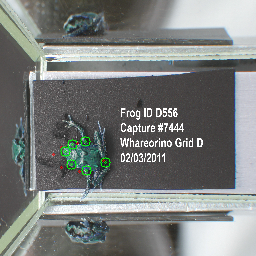

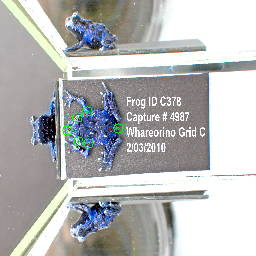

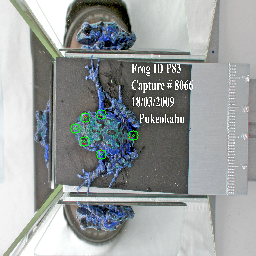

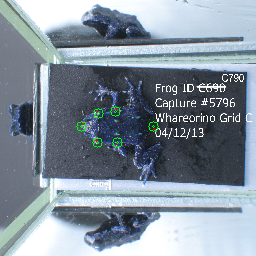

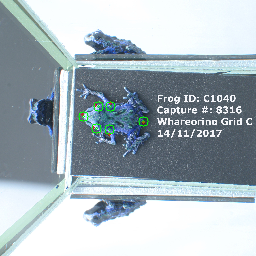

5


In [ ]:
x, y = gtest.__getitem__(1)
pred = my_model.predict(x)
# m = LocalizationPointAccuracy(radius = 10)
counter = 0
for j in range(1):
    for i in range(5):
        # m.reset_states()
        # m.update_state(y[i], pred[i])
        counter += 1
        show_labels(
            x[i], pred[i], labels_real=y[i], radius=1, thickness=1, radius_real=5
        )
print(counter)

In [ ]:
len(test_df)

167

In [ ]:
mobilenet = keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling=None,
    dropout_rate=0,
)

6701056/6698480 [==============================] - 0s 0us/step


In [ ]:
mobilenet.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [ ]:
my_model.predict(gtest)

array([[ 97.81583 , 140.9659  , 121.93631 , ..., 124.33917 , 165.46318 ,
        126.88092 ],
       [ 87.73563 , 161.68362 , 101.494804, ..., 149.81654 , 120.18561 ,
        153.18724 ],
       [ 81.329704, 148.1555  ,  96.260284, ..., 133.74486 , 126.8597  ,
        130.91081 ],
       ...,
       [ 49.96332 , 135.80945 ,  66.67343 , ..., 119.02823 ,  94.1443  ,
        127.58199 ],
       [ 92.685684, 152.99068 , 113.56134 , ..., 136.48729 , 157.39522 ,
        135.25197 ],
       [116.99947 , 117.14334 , 118.53624 , ..., 100.38926 , 134.12202 ,
        173.4135  ]], dtype=float32)